# Moderation of Self-Determination on AI Acceptance

Goal:
- Test Hypothesis 2 (H2): Whether the association between Self-Determination (TENS_Life_mean) and AI acceptance for mental-health applications  (UTAUT_AI_mean) is moderated by general AI attitudes (GAAIS_mean).

Model: UTAUT_AI_mean ~ TENS_c * GAAIS_c + age_c + C(gender) + C(Country)

Key Steps:
- Load merged cross-cultural dataset
- Define H2 analysis sample
- Center continuous predictors
- Fit main-effects and interaction models
- Inspect coefficients, R², and diagnostics
- Prepare simple slopes / plot-ready data for interpretation

# 0.0 Imports and Path Setup

In [71]:
from __future__ import annotations

import warnings
from pathlib import Path
from typing import Dict, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor

warnings.filterwarnings("ignore", category=FutureWarning)

PROJECT_ROOT = Path.cwd()
DATA_DIR = PROJECT_ROOT / "data"
OUTPUT_DIR = DATA_DIR / "output"
PROCESSED_PATH = OUTPUT_DIR / "processed.csv"

# 1.0 Define H2 Analysis Sample

Goal of H2: Test whether general AI attitudes (GAAIS) moderate the association between self-determination (TENS) and global AI acceptance for mental-health interventions (UTAUT_AI_mean).

- Outcome: UTAUT_AI_mean_imputed

- Predictor (SDT): TENS_Life_mean_imputed

- Moderator: GAAIS_mean_imputed

- Covariates: age_imputed, gender, Country (China vs USA; covariate, not moderator here)

In [72]:
processed = pd.read_csv(PROCESSED_PATH)
print("Processed shape:", processed.shape)

Processed shape: (2342, 283)


In [73]:
h2_vars = [
    "UTAUT_AI_mean_imputed",    # outcome
    "TENS_Life_mean_imputed",   # SDT predictor
    "GAAIS_mean_imputed",       # moderator
    "age_imputed",              # covariate
    "gender",                   # covariate (categorical)
    "Country",                  # covariate (China vs USA)
]

h2_df = processed[h2_vars].copy()

## 1.1. Keep rows with non-missing categorical covariates

In [74]:
n_total = len(h2_df)
h2_df = h2_df.dropna(subset=["gender", "Country"])
n_analytic = len(h2_df)

In [75]:
print("H2 analytic sample:")
print(f"Total N in processed: {n_total}")
print(f"N with non-missing gender & Country: {n_analytic}")

H2 analytic sample:
Total N in processed: 2342
N with non-missing gender & Country: 2227


In [76]:
print("Country distribution (H2 sample):")
print(h2_df["Country"].value_counts(dropna=False))

Country distribution (H2 sample):
Country
USA      1742
China     485
Name: count, dtype: int64


In [77]:
print("Gender distribution (H2 sample):")
print(h2_df["gender"].value_counts(dropna=False))

Gender distribution (H2 sample):
gender
1.0    1204
2.0     971
3.0      45
4.0       7
Name: count, dtype: int64


# 2.0 Descriptive Statistics and Correlations (H2)

We describe the continuous variables and inspect basic correlations among SDT, GAAIS, age, and global AI acceptance.

In [78]:
continuous_h2 = [
    "UTAUT_AI_mean_imputed",
    "TENS_Life_mean_imputed",
    "GAAIS_mean_imputed",
    "age_imputed",
]

print("Descriptive statistics (H2 continuous variables):")
display(h2_df[continuous_h2].describe().T)

Descriptive statistics (H2 continuous variables):


,count,mean,std,min,25%,50%,75%,max
UTAUT_AI_mean_imputed,2227.0,4.780828,1.368618,1.115385,3.448718,5.000,6.00,7.814815
TENS_Life_mean_imputed,2227.0,4.764543,0.998003,1.000000,4.111111,4.875,5.50,7.000000
GAAIS_mean_imputed,2227.0,4.610833,0.794880,2.000000,4.000000,4.625,5.25,6.000000
age_imputed,2227.0,34.158509,17.157023,1.000000,23.000000,32.000,46.00,85.000000


In [79]:
# Correlation matrix
corr_h2 = h2_df[continuous_h2].corr()
print("Correlation matrix (H2):")
display(corr_h2.round(3))

Correlation matrix (H2):


,UTAUT_AI_mean_imputed,TENS_Life_mean_imputed,GAAIS_mean_imputed,age_imputed
UTAUT_AI_mean_imputed,1.000,0.156,0.124,0.147
TENS_Life_mean_imputed,0.156,1.000,0.235,0.215
GAAIS_mean_imputed,0.124,0.235,1.000,0.113
age_imputed,0.147,0.215,0.113,1.000


# 3.0 Center Continuous Predictors

We mean-center SDT (TENS), general AI attitudes (GAAIS), and age for interpretability and to align with moderation conventions.

In [80]:
center_cols_h2 = ["TENS_Life_mean_imputed", "GAAIS_mean_imputed", "age_imputed"]

for col in center_cols_h2:
    mean_val = h2_df[col].mean()
    h2_df[f"{col}_c"] = h2_df[col] - mean_val
    print(f"{col} mean for centering: {mean_val:.3f}")

TENS_Life_mean_imputed mean for centering: 4.765
GAAIS_mean_imputed mean for centering: 4.611
age_imputed mean for centering: 34.159


In [81]:
print("Means of centered variables (should be ≈ 0):")
print(h2_df[[f"{c}_c" for c in center_cols_h2]].mean())

Means of centered variables (should be ≈ 0):
TENS_Life_mean_imputed_c   -1.659103e-16
GAAIS_mean_imputed_c        2.552466e-16
age_imputed_c              -4.083946e-16
dtype: float64


# 4.0 Baseline H2 Model – Main Effects Only

We first estimate a main-effects model without the interaction:

UTAUT_AI = β_0 + β_1 TENS_c + β_2 GAAIS_c + β_3 age_c + β_4 gender + β_5 Country + 𝜀

In [82]:
formula_h2_main = (
    "UTAUT_AI_mean_imputed ~ "
    "TENS_Life_mean_imputed_c + GAAIS_mean_imputed_c "
    "+ age_imputed_c + C(gender) + C(Country)"
)

h2_main_model = smf.ols(formula=formula_h2_main, data=h2_df).fit()

print("H2 Baseline (main effects only) model summary:")
display(h2_main_model.summary())

H2 Baseline (main effects only) model summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     UTAUT_AI_mean_imputed   R-squared:                       0.258
Model:                               OLS   Adj. R-squared:                  0.255
Method:                    Least Squares   F-statistic:                     109.9
Date:                   Sun, 30 Nov 2025   Prob (F-statistic):          1.41e-138
Time:                           16:27:05   Log-Likelihood:                -3526.8
No. Observations:                   2227   AIC:                             7070.
Df Residuals:                       2219   BIC:                             7115.
Df Model:                              7                                         
Covariance Type:               nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    3.1896      0.074     43.206      0.000       3.045       3.334
C(gender)[T.2.0]            -0.0591      0.052     -1.139      0.255      -0.161       0.043
C(gender)[T.3.0]             0.1630      0.180      0.904      0.366      -0.191       0.517
C(gender)[T.4.0]             0.5513      0.448      1.230      0.219      -0.327       1.430
C(Country)[T.USA]            2.0608      0.083     24.866      0.000       1.898       2.223
TENS_Life_mean_imputed_c     0.0684      0.027      2.554      0.011       0.016       0.121
GAAIS_mean_imputed_c         0.2273      0.033      6.899      0.000       0.163       0.292
age_imputed_c               -0.0236      0.002    -11.835      0.000      -0.028      -0.020
==============================================================================
Omnibus:                      164.313   Durbin-Watson:                   1.341
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              101.762
Skew:                          -0.394   Prob(JB):                     7.99e-23
Kurtosis:                       2.309   Cond. No.                         307.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [83]:
print(f"R² (H2 main-effects model): {h2_main_model.rsquared:.3f}")

R² (H2 main-effects model): 0.258


In [84]:
print(f"Adj. R² (H2 main-effects model): {h2_main_model.rsquared_adj:.3f}")

Adj. R² (H2 main-effects model): 0.255


# 5.0. Full H2 Model – SDT × GAAIS Interaction

We add the interaction between SDT and general AI attitudes:

UTAUT_AI = β_0 + β_1 TENS_c + β_2 GAAIS_c + β_3 (TENS_c × GAAIS_c) + covariates + 𝜀

In [85]:
# Full H2 model with interaction term
formula_h2_full = (
    "UTAUT_AI_mean_imputed ~ "
    "TENS_Life_mean_imputed_c * GAAIS_mean_imputed_c "
    "+ age_imputed_c + C(gender) + C(Country)"
)

h2_full_model = smf.ols(formula=formula_h2_full, data=h2_df).fit()

print("H2 Full model (with interaction) summary:")
display(h2_full_model.summary())

H2 Full model (with interaction) summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     UTAUT_AI_mean_imputed   R-squared:                       0.259
Model:                               OLS   Adj. R-squared:                  0.256
Method:                    Least Squares   F-statistic:                     96.69
Date:                   Sun, 30 Nov 2025   Prob (F-statistic):          3.18e-138
Time:                           16:27:05   Log-Likelihood:                -3525.2
No. Observations:                   2227   AIC:                             7068.
Df Residuals:                       2218   BIC:                             7120.
Df Model:                              8                                         
Covariance Type:               nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Intercept                                         3.1953      0.074     43.263      0.000       3.050       3.340
C(gender)[T.2.0]                                 -0.0634      0.052     -1.221      0.222      -0.165       0.038
C(gender)[T.3.0]                                  0.1551      0.180      0.861      0.390      -0.198       0.509
C(gender)[T.4.0]                                  0.5733      0.448      1.279      0.201      -0.305       1.452
C(Country)[T.USA]                                 2.0430      0.083     24.484      0.000       1.879       2.207
TENS_Life_mean_imputed_c                          0.0624      0.027      2.313      0.021       0.010       0.115
GAAIS_mean_imputed_c                              0.2258      0.033      6.851      0.000       0.161       0.290
TENS_Life_mean_imputed_c:GAAIS_mean_imputed_c     0.0549      0.031      1.779      0.075      -0.006       0.115
age_imputed_c                                    -0.0238      0.002    -11.904      0.000      -0.028      -0.020
==============================================================================
Omnibus:                      165.233   Durbin-Watson:                   1.346
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              103.312
Skew:                          -0.399   Prob(JB):                     3.68e-23
Kurtosis:                       2.310   Cond. No.                         307.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [86]:
print(f"R² (H2 full model): {h2_full_model.rsquared:.3f}")

R² (H2 full model): 0.259


In [87]:
print(f"Adj. R² (H2 full model): {h2_full_model.rsquared_adj:.3f}")

Adj. R² (H2 full model): 0.256


## 5.1. Extract Key Composite

In [88]:
print("Key H2 coefficients:")
display(
    h2_full_model.params[[
        "TENS_Life_mean_imputed_c",
        "GAAIS_mean_imputed_c",
        "TENS_Life_mean_imputed_c:GAAIS_mean_imputed_c"
    ]]
)

Key H2 coefficients:


TENS_Life_mean_imputed_c                         0.062400
GAAIS_mean_imputed_c                             0.225753
TENS_Life_mean_imputed_c:GAAIS_mean_imputed_c    0.054895
dtype: float64

In [89]:
print("Key H2 p-values:")
display(
    h2_full_model.pvalues[[
        "TENS_Life_mean_imputed_c",
        "GAAIS_mean_imputed_c",
        "TENS_Life_mean_imputed_c:GAAIS_mean_imputed_c"
    ]]
)

Key H2 p-values:


TENS_Life_mean_imputed_c                         2.080192e-02
GAAIS_mean_imputed_c                             9.447582e-12
TENS_Life_mean_imputed_c:GAAIS_mean_imputed_c    7.530489e-02
dtype: float64

# 6.0. Model Comparison: Main Effects VS Interaction

We compare the main-effects model vs. the interaction model using ANOVA and ΔR².

In [90]:
print("ANOVA comparison: main-effects vs interaction model (H2)")
anova_results = anova_lm(h2_main_model, h2_full_model)
display(anova_results)

ANOVA comparison: main-effects vs interaction model (H2)


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2219.0,3095.813042,0.0,NaN,NaN,NaN
1,2218.0,3091.399784,1.0,4.413258,3.166399,0.075305


Adding the interaction term reduced the residual error (SSR dropped from 3095.81 → 3091.40), But this reduction is not statistically significant:
- F = 3.17
- p = 0.075 (above .05 but suggestive)

In [91]:
r2_main = h2_main_model.rsquared
r2_full = h2_full_model.rsquared
delta_r2 = r2_full - r2_main

print(f"R² (main effects): {r2_main:.3f}")
print(f"R² (full with interaction): {r2_full:.3f}")
print(f"ΔR² due to interaction: {delta_r2:.3f}")

R² (main effects): 0.258
R² (full with interaction): 0.259
ΔR² due to interaction: 0.001


# 9.0. Multicollinearity Check
- Build design matrix for VIF (excluding intercept)
- Use the same structure as the full H2 model

In [92]:
X_h2 = h2_full_model.model.exog
vif_data_h2 = []

for i, name in enumerate(h2_full_model.model.exog_names):
    if name == "Intercept":
        continue
    vif = variance_inflation_factor(X_h2, i)
    vif_data_h2.append({"Predictor": name, "VIF": vif})

vif_h2_df = pd.DataFrame(vif_data_h2).sort_values("VIF", ascending=False)

print("Variance Inflation Factors (H2 full model):")
display(vif_h2_df)

Variance Inflation Factors (H2 full model):


,Predictor,VIF
3,C(Country)[T.USA],1.895149
7,age_imputed_c,1.874583
4,TENS_Life_mean_imputed_c,1.157517
5,GAAIS_mean_imputed_c,1.095615
6,TENS_Life_mean_imputed_c:GAAIS_mean_imputed_c,1.077428
0,C(gender)[T.2.0],1.060269
1,C(gender)[T.3.0],1.027907
2,C(gender)[T.4.0],1.005086


# 10.0. Residual Diagnostics (H2 Full Model)

We check linearity, homoscedasticity, and residual distribution.

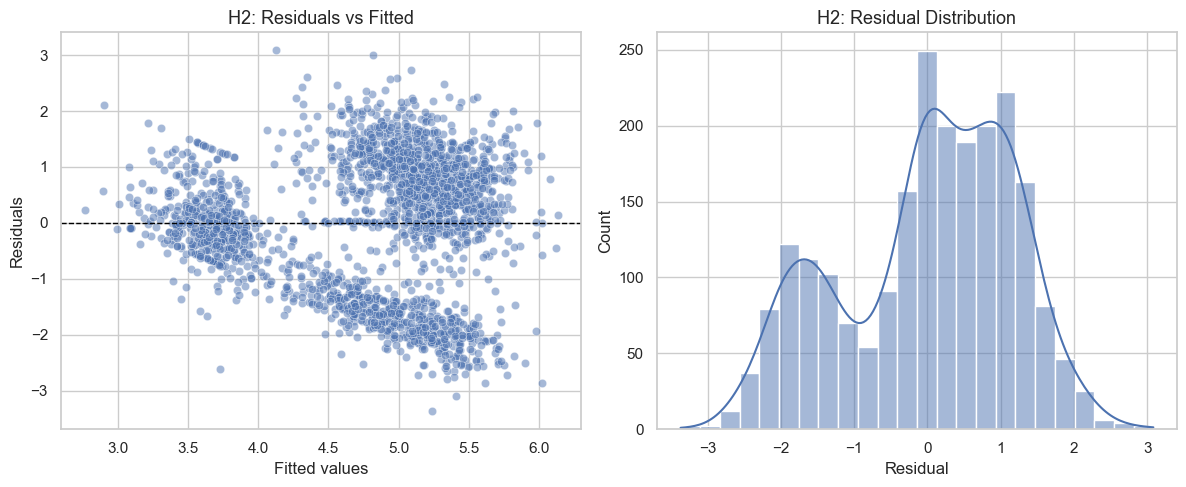

In [97]:
# Standardized residuals and fitted values
h2_df["resid_h2"] = h2_full_model.resid
h2_df["fitted_h2"] = h2_full_model.fittedvalues

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Residuals vs fitted values
sns.scatterplot(
    x="fitted_h2",
    y="resid_h2",
    data=h2_df,
    ax=axes[0],
    alpha=0.5
)
axes[0].axhline(0, color="black", linestyle="--", linewidth=1)
axes[0].set_xlabel("Fitted values")
axes[0].set_ylabel("Residuals")
axes[0].set_title("H2: Residuals vs Fitted")

# Residual distribution
sns.histplot(h2_df["resid_h2"], kde=True, ax=axes[1])
axes[1].set_xlabel("Residual")
axes[1].set_title("H2: Residual Distribution")

plt.tight_layout()
plt.show()

# 11.0. Simple Slopes / Plot-Ready Data (Low / Mean / High GAAIS)

Even if the interaction is non-significant, reviewers often like seeing simple slopes for interpretability. Here we generate predicted UTAUT scores across SDT levels at low / mean / high GAAIS (±1 SD).

In [95]:
# Ensure centered columns exist
for col in ["TENS_Life_mean_imputed", "GAAIS_mean_imputed", "age_imputed"]:
    c_name = f"{col}_c"
    if c_name not in h2_df.columns:
        h2_df[c_name] = h2_df[col] - h2_df[col].mean()

# Create +/- 1 SD values of moderator (GAAIS) on the *centered* scale
g_mean = h2_df["GAAIS_mean_imputed_c"].mean()   # should be ~0
g_sd   = h2_df["GAAIS_mean_imputed_c"].std()

g_levels = {
    "low_GAAIS":  g_mean - g_sd,
    "mean_GAAIS": g_mean,
    "high_GAAIS": g_mean + g_sd,
}

# Range of TENS (centered) values for simple slopes
tens_min = h2_df["TENS_Life_mean_imputed_c"].min()
tens_max = h2_df["TENS_Life_mean_imputed_c"].max()

tens_grid_c = np.linspace(tens_min, tens_max, 50)

pred_rows = []

for level_name, g_val in g_levels.items():
    for t_val in tens_grid_c:
        row = {
            "TENS_Life_mean_imputed_c": t_val,
            "GAAIS_mean_imputed_c":    g_val,
            "age_imputed_c":           0.0,  # mean-centered age
            "gender":                  h2_df["gender"].mode()[0],
            "Country":                 h2_df["Country"].mode()[0],
            "GAAIS_level":             level_name,
        }
        pred_rows.append(row)

pred_df = pd.DataFrame(pred_rows)

# Use the fitted full H2 model (with interaction) to get predictions
pred_df["UTAUT_pred"] = h2_full_model.predict(pred_df)

# Add a raw-scale TENS variable for nicer plotting
tens_raw_mean = h2_df["TENS_Life_mean_imputed"].mean()
pred_df["TENS_Life_raw"] = pred_df["TENS_Life_mean_imputed_c"] + tens_raw_mean

display(pred_df.head())

,TENS_Life_mean_imputed_c,GAAIS_mean_imputed_c,age_imputed_c,gender,Country,GAAIS_level,UTAUT_pred,TENS_Life_raw
0,-3.764543,-0.79488,0.0,1.0,USA,low_GAAIS,4.988178,1.000000
1,-3.642094,-0.79488,0.0,1.0,USA,low_GAAIS,4.990476,1.122449
2,-3.519645,-0.79488,0.0,1.0,USA,low_GAAIS,4.992774,1.244898
3,-3.397196,-0.79488,0.0,1.0,USA,low_GAAIS,4.995071,1.367347
4,-3.274747,-0.79488,0.0,1.0,USA,low_GAAIS,4.997369,1.489796


# 12.0. Plot simple slopes of TENS → UTAUT at different GAAIS levels

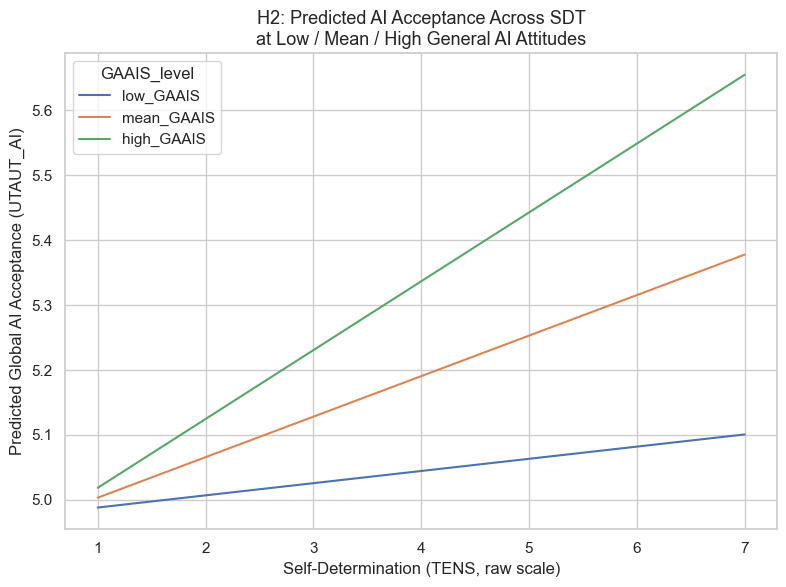

In [96]:
plt.figure(figsize=(8, 6))
sns.lineplot(
    data=pred_df,
    x="TENS_Life_raw",
    y="UTAUT_pred",
    hue="GAAIS_level"
)
plt.xlabel("Self-Determination (TENS, raw scale)")
plt.ylabel("Predicted Global AI Acceptance (UTAUT_AI)")
plt.title("H2: Predicted AI Acceptance Across SDT\nat Low / Mean / High General AI Attitudes")
plt.tight_layout()
plt.show()

# Narrative Summary

In [98]:
beta_sdt = h2_full_model.params["TENS_Life_mean_imputed_c"]
p_sdt = h2_full_model.pvalues["TENS_Life_mean_imputed_c"]

beta_gaais = h2_full_model.params["GAAIS_mean_imputed_c"]
p_gaais = h2_full_model.pvalues["GAAIS_mean_imputed_c"]

beta_int = h2_full_model.params["TENS_Life_mean_imputed_c:GAAIS_mean_imputed_c"]
p_int = h2_full_model.pvalues["TENS_Life_mean_imputed_c:GAAIS_mean_imputed_c"]

print(
    f"In the H2 model, higher self-determination (SDT; TENS) was associated with "
    f"greater global acceptance of AI mental-health interventions "
    f"(β = {beta_sdt:.3f}, p = {p_sdt:.3g}), controlling for age, gender, country, "
    f"and general AI attitudes.\n"
    f"General AI attitudes (GAAIS) also showed a positive association with global AI acceptance "
    f"(β = {beta_gaais:.3f}, p = {p_gaais:.3g}).\n"
    f"The SDT × GAAIS interaction term was "
    f"{'statistically significant' if p_int < 0.05 else 'not statistically significant'} "
    f"(β = {beta_int:.3f}, p = {p_int:.3g}), and the inclusion of the interaction changed R² by "
    f"ΔR² = {delta_r2:.3f} relative to the main-effects model."
)

In the H2 model, higher self-determination (SDT; TENS) was associated with greater global acceptance of AI mental-health interventions (β = 0.062, p = 0.0208), controlling for age, gender, country, and general AI attitudes.
General AI attitudes (GAAIS) also showed a positive association with global AI acceptance (β = 0.226, p = 9.45e-12).
The SDT × GAAIS interaction term was not statistically significant (β = 0.055, p = 0.0753), and the inclusion of the interaction changed R² by ΔR² = 0.001 relative to the main-effects model.
